# Fusion of three ideas: Deep Image Prior, CSGM, AE. DIP is a type of CSGM but uses the CNN architecture as the prior. CSGM trains a generative model, but these are expensive to train. We will train a simple non-probabilistic AE and then minimize energy like DIP.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../kaisr

/home/remedios/kaisr/kaisr


In [3]:
import nibabel as nib
import numpy as np
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import torch

from utils.plot import *
from tqdm import tqdm
from models.ae import *

In [4]:
torch.backends.cudnn.benchmark = True
set_display_mode(mode='dark')
DTYPE = np.float32
device = torch.device(f'cuda:2')

In [5]:
fpath = Path("../../data/ADNI/ADNI_phantom_1mm_inplane_header_corrected/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled.nii")
vol = nib.load(fpath).get_fdata(dtype=DTYPE)

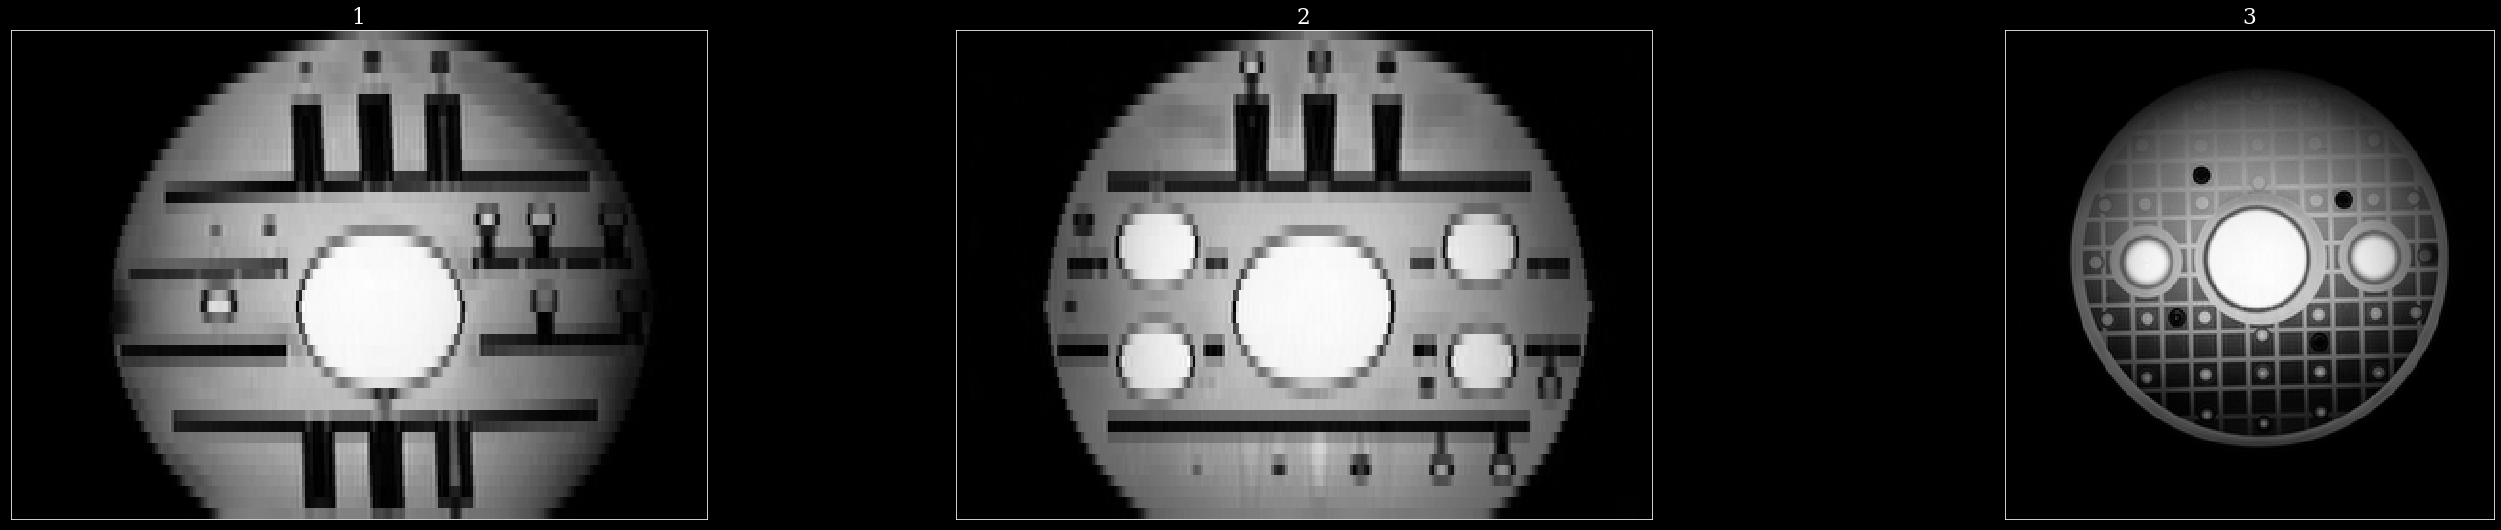

In [6]:
center_vol_plot(vol, target_shape=(256, 256, 180))

In [7]:
from utils.train_loader_slices import TrainSet
from torch.utils.data import DataLoader

In [8]:
batch_size = vol.shape[-1]
n_iters = 5000

In [9]:
ds = TrainSet(
    img_fpath=fpath,
    n_iters=n_iters,
    slice_axis=2,
)

data_loader = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True, 
    pin_memory=True,
    num_workers=4,
)

In [10]:
x = ds.get_all_slices_as_tensor().to(device)

In [11]:
model = AE(in_channels=1, filters=128, network_depth=2).to(device)

In [12]:
lr = 1e-1
opt = torch.optim.Adam(model.parameters(), lr=lr)

In [13]:
N_STEPS = n_iters
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=opt,
    max_lr=lr,
    total_steps=N_STEPS+1,
    cycle_momentum=True,
)
opt.zero_grad()
opt.step()

In [14]:
recon_loss = nn.MSELoss()

In [15]:
with tqdm(total=n_iters) as pbar:    
    pbar_dict = {
        'loss': np.finfo(np.float32).max,
    }
    
    for cur_step in range(n_iters):
#     for cur_step, imgs in enumerate(data_loader):
        opt.zero_grad()

#         x = imgs.to(device)
        x_hat = model(x)

        loss = recon_loss(x_hat, x)
        loss.backward()
        opt.step()

        scheduler.step()

        pbar_dict['loss'] = loss.detach().cpu().numpy().item()

        pbar.set_postfix({k: f'{v:.4f}' for k, v in pbar_dict.items()})
        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [13:54<00:00,  5.99it/s, loss=0.0002]


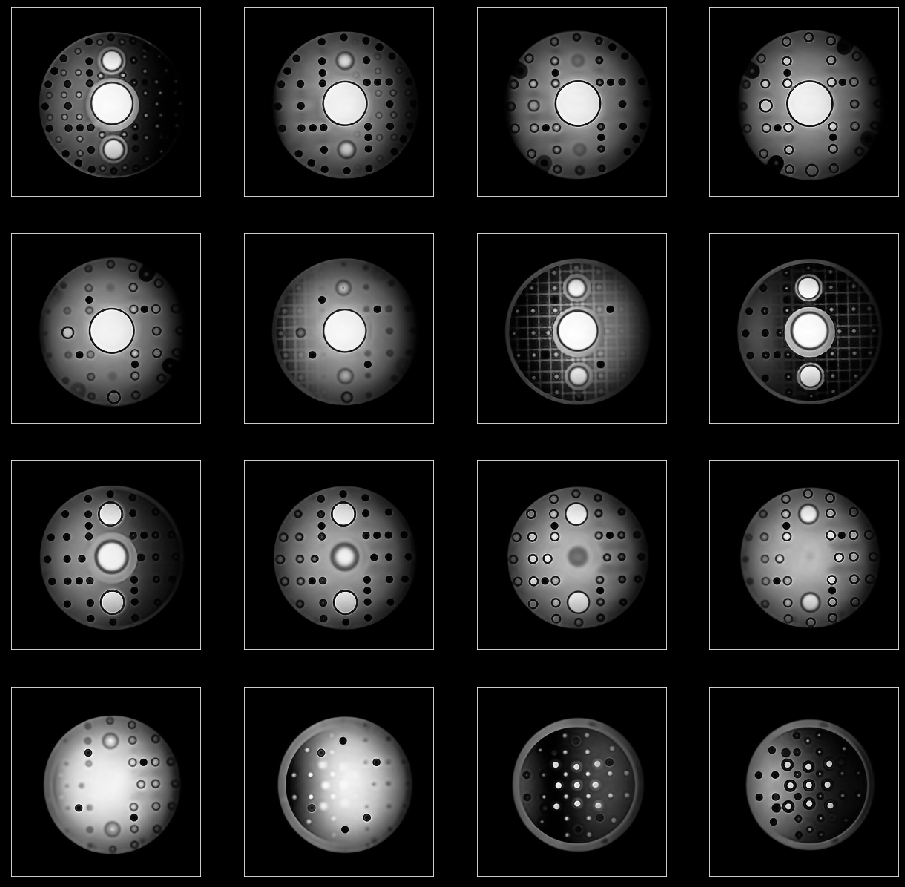

In [16]:
# visualize 16 encodings
gts = [ds.__getitem__(i) for i in range(16, 32)]
gts = torch.from_numpy(np.array(gts)).to(device)

encodings = model(gts).detach().cpu().numpy().squeeze()

fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i, ax in enumerate(axs.flat):
    ax.imshow(encodings[i])
    ax.set_xticks([])
    ax.set_yticks([])

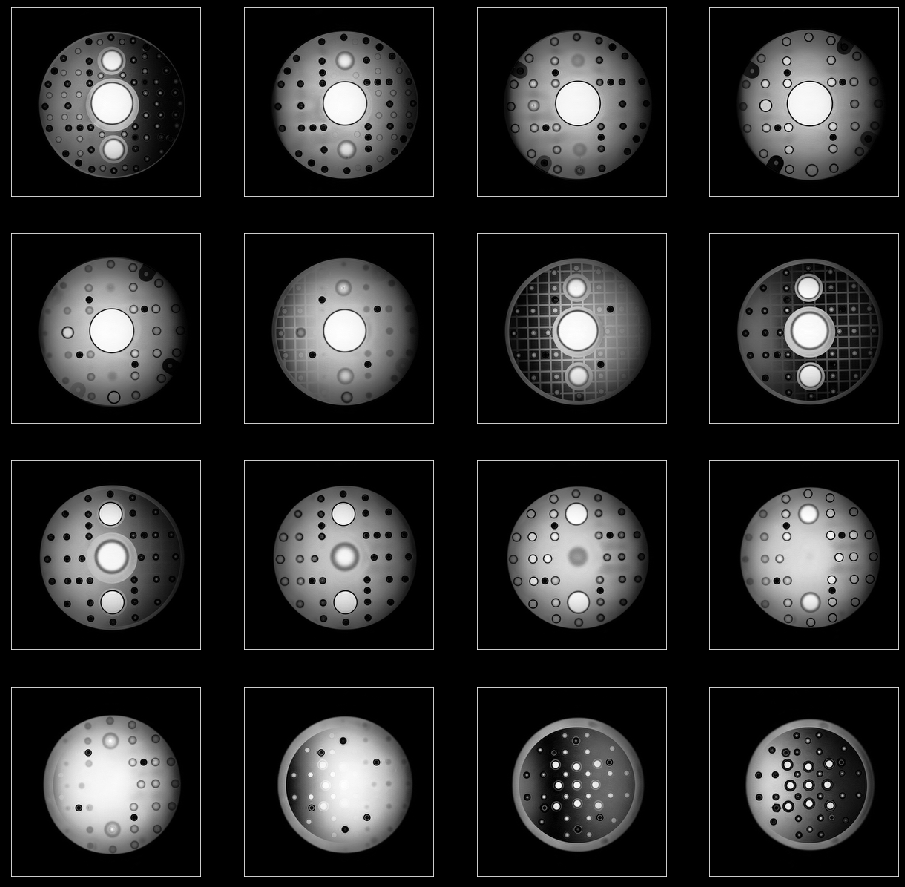

In [17]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

for i, ax in enumerate(axs.flat):
    ax.imshow(gts[i].detach().cpu().numpy().squeeze())
    ax.set_xticks([])
    ax.set_yticks([])

# Compressed Sensing

In [18]:
# we now have a (not great) model of in-plane slices that generates 256x256 images.
# We want to try finding a HR image using this model as a prior which degrades
# to our observation

In [19]:
obs = vol[128]

In [20]:
# in this case, we're doing 4x super resolution; the kernel will downsample by 4
# and also convolve with a filter. so our observation should be 256 x (256/4)

In [21]:
256/4

64.0

In [22]:
obs = np.pad(obs, ((0, 0), (19, 0)))
# we'll crop later

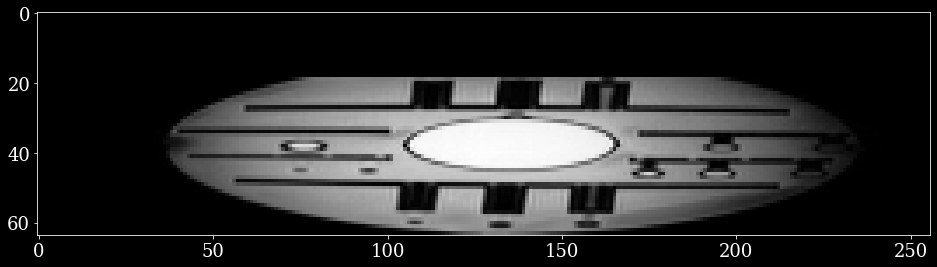

In [23]:
plt.imshow(obs.T)

In [845]:
# Write the kernel as a torch module
from utils.kernel import *

In [28]:
fwhm = fwhm_needed(1, 4)

In [29]:
std = fwhm_to_std(fwhm)

In [30]:
slice_profile = gaussian(M=17, std=std, sym=True).astype(np.float32)

In [31]:
A = DegradationKernel(scale_factor=1/4, blur_kernel=slice_profile, device=device).to(device)

In [32]:
img = vol[:, :, 23].astype(np.float32)

In [33]:
img = torch.from_numpy(img).unsqueeze(1)

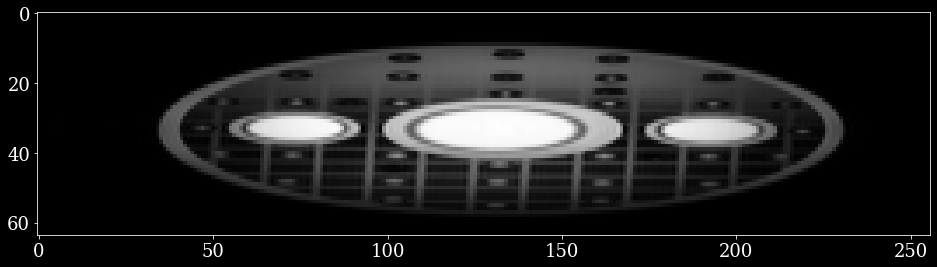

In [34]:
plt.imshow(A(img.to(device)).detach().cpu().numpy().squeeze().T)

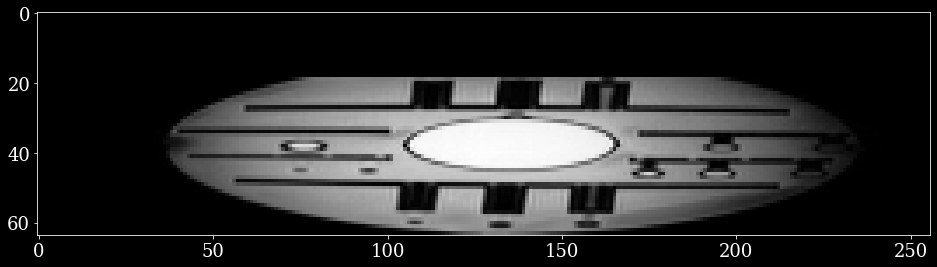

In [35]:
plt.imshow(obs.squeeze().T)

# Testing new code

In [450]:
from utils.ilo import *

In [510]:
# set up loss functions
losses = {
    'mse': torch.nn.MSELoss().to(device),
    'lpips': lpips.LPIPS(net='vgg').to(device),
}

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/remedios/miniconda3/envs/kaisr/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


In [540]:
def mse(a, b):
    return ((a - b) ** 2).sum()

In [1020]:
def pred_to_img(G, z, pad, scale):
    with torch.no_grad():
        ret = G(z).detach().cpu().numpy().squeeze()[:, int(pad*scale):]
    return ret

In [1021]:
def project_onto_l1_ball(x, eps):
    """
    From ILO code
    
    See: https://gist.github.com/tonyduan/1329998205d88c566588e57e3e2c0c55
    """
    original_shape = x.shape
    x = x.view(x.shape[0], -1)
    mask = (torch.norm(x, p=1, dim=1) < eps).float().unsqueeze(1)
    mu, _ = torch.sort(torch.abs(x), dim=1, descending=True)
    cumsum = torch.cumsum(mu, dim=1)
    arange = torch.arange(1, x.shape[1] + 1, device=x.device)
    rho, _ = torch.max((mu * arange > (cumsum - eps)) * arange, dim=1)
    theta = (cumsum[torch.arange(x.shape[0]), rho.cpu() - 1] - eps) / rho
    proj = (torch.abs(x) - theta.unsqueeze(1)).clamp(min=0)
    x = mask * x + (1 - mask) * proj * torch.sign(x)
    return x.view(original_shape)

In [994]:
A = DegradationKernel(scale_factor=1/4, blur_kernel=slice_profile, device=device, mode='nearest').to(device)

In [995]:
gt_vol = nib.load(Path("../../data/ADNI/ADNI_phantom_1mm_inplane_header_corrected/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-01mm_resampled.nii")).get_fdata(dtype=DTYPE)

In [996]:
gt = gt_vol[128]
gt, *_ = normalize(gt)

In [1022]:
# set up observation to initialize z
obs = vol[128]

pad = 19
scale = 4
obs = np.pad(obs, ((0, 0), (pad, 0)))
obs, orig_min, orig_max = normalize(obs)

obs_interp = resize(obs, (1, 1/scale), order=5)
obs_interp = torch.from_numpy(obs_interp).unsqueeze(0).unsqueeze(1).to(device)

obs = torch.from_numpy(obs).to(device)

In [1023]:
from utils.ilo import *

In [1024]:
G = nn.Sequential(*list(model.decoder.children()), model.tail)
# ensure G is frozen
for p in G.parameters():
    p.requires_grad=False

In [1025]:
lrs = [1e-4, 1e-5, 1e-6]
n_iters = [400, 200, 200]
N_ILO_LAYERS = 2
R = 3
l1_epsilons = [100, 1000, 5000]

In [1028]:
preds = ilo(G, z_init, obs, A, lrs, n_iters, N_ILO_LAYERS, R, l1_epsilons, pad, scale, device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/remedios/miniconda3/envs/kaisr/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth
########## CSGM Layer 0 ##########


100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 99.28it/s, loss=0.0756, mse=0.0347, lpips=0.0409]


########## L1 Ball Layer 1 ##########


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 611.48it/s, mse=0.0002]


########## CSGM Layer 1 ##########


100%|█████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 100.10it/s, loss=0.0725, mse=0.0328, lpips=0.0396]


########## L1 Ball Layer 2 ##########


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 399.94it/s, mse=0.0000]


Auto-encoded MSE: 2426.1685


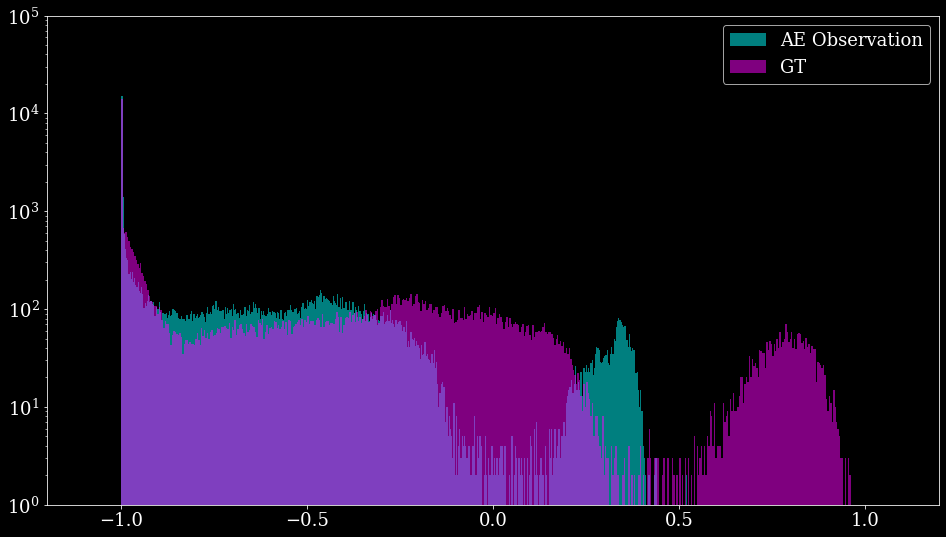

Interp MSE: 755.8278


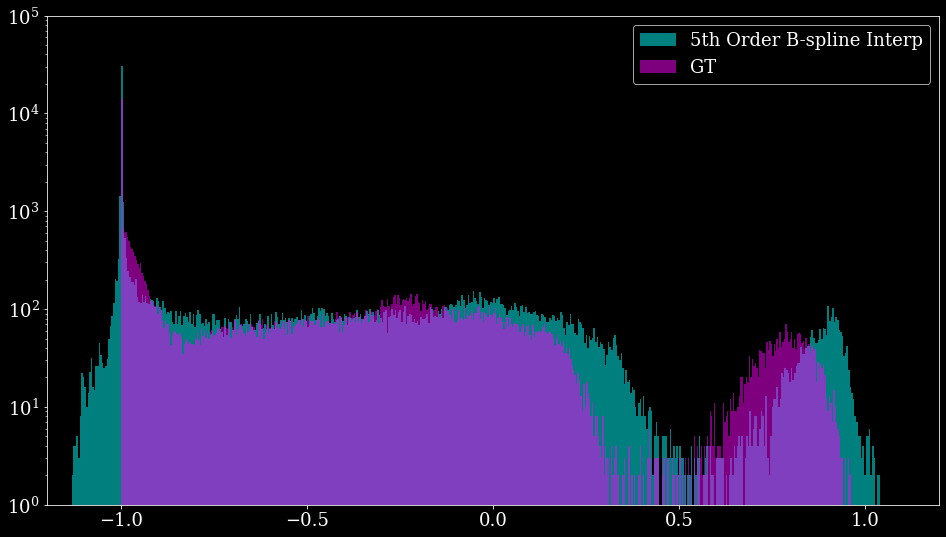

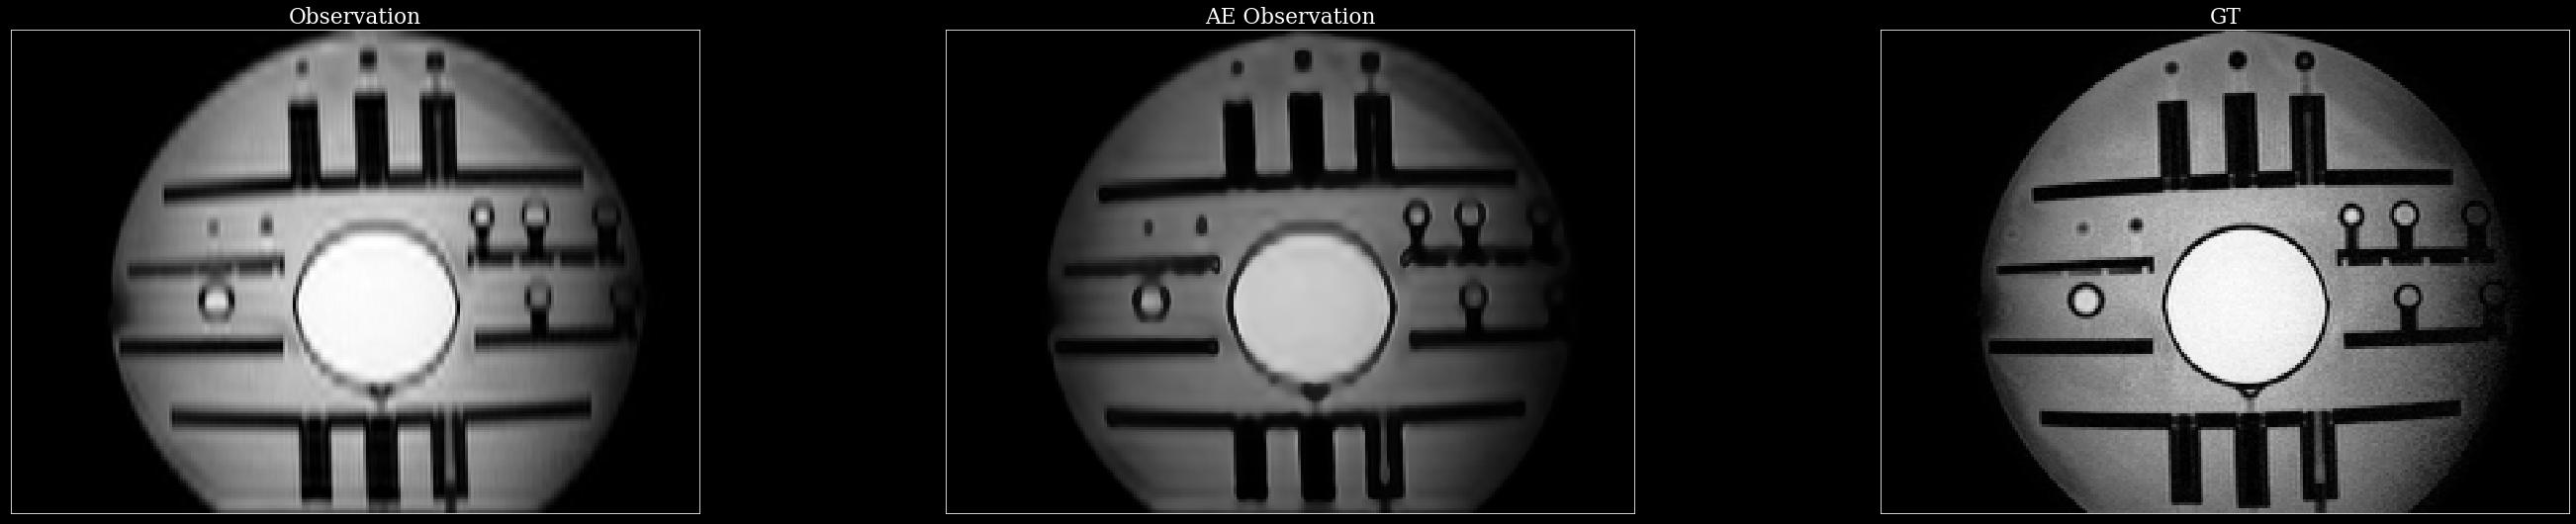

========== ILO at level 0 ==========
SR MSE: 1843.2714


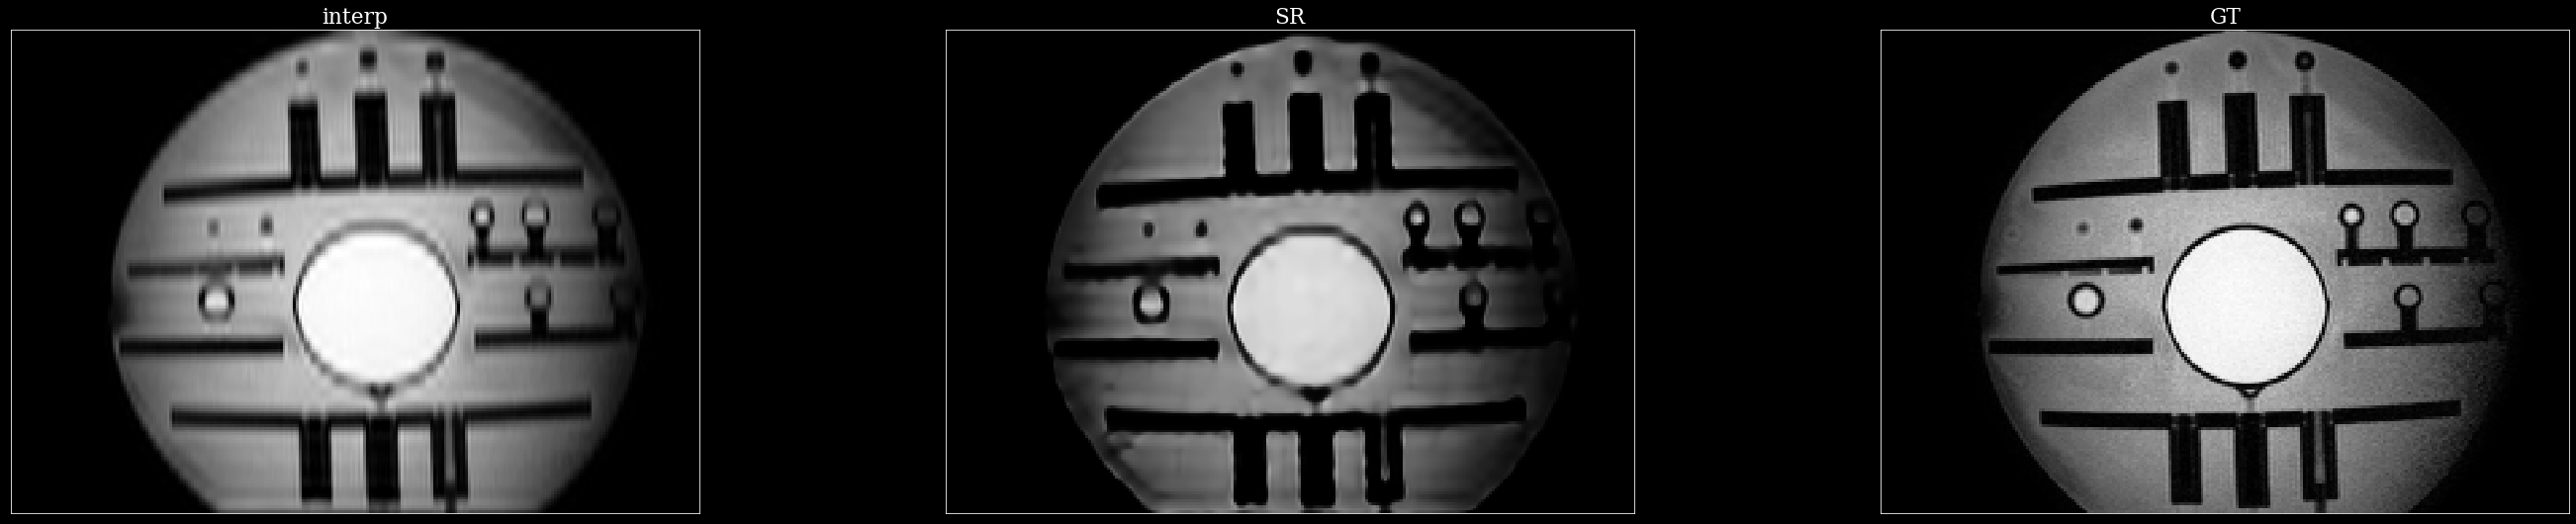

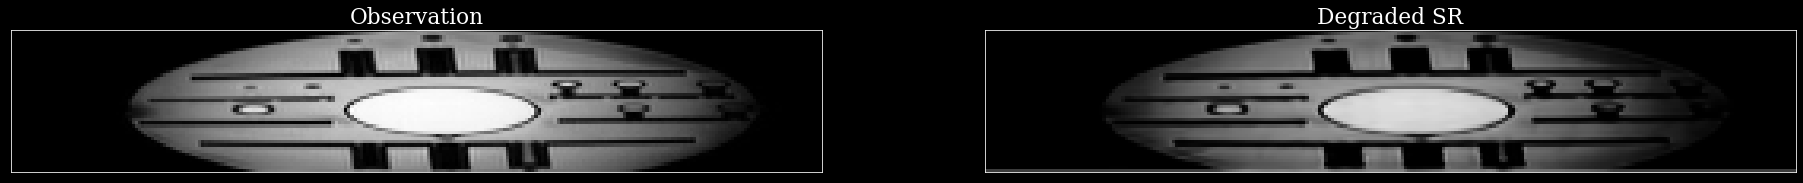

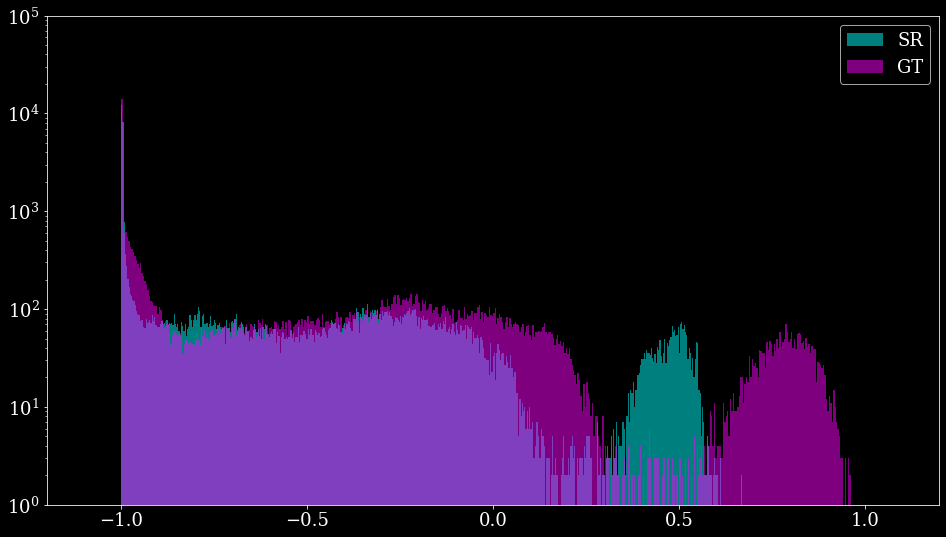

========== ILO at level 1 ==========
SR MSE: 2416.5188


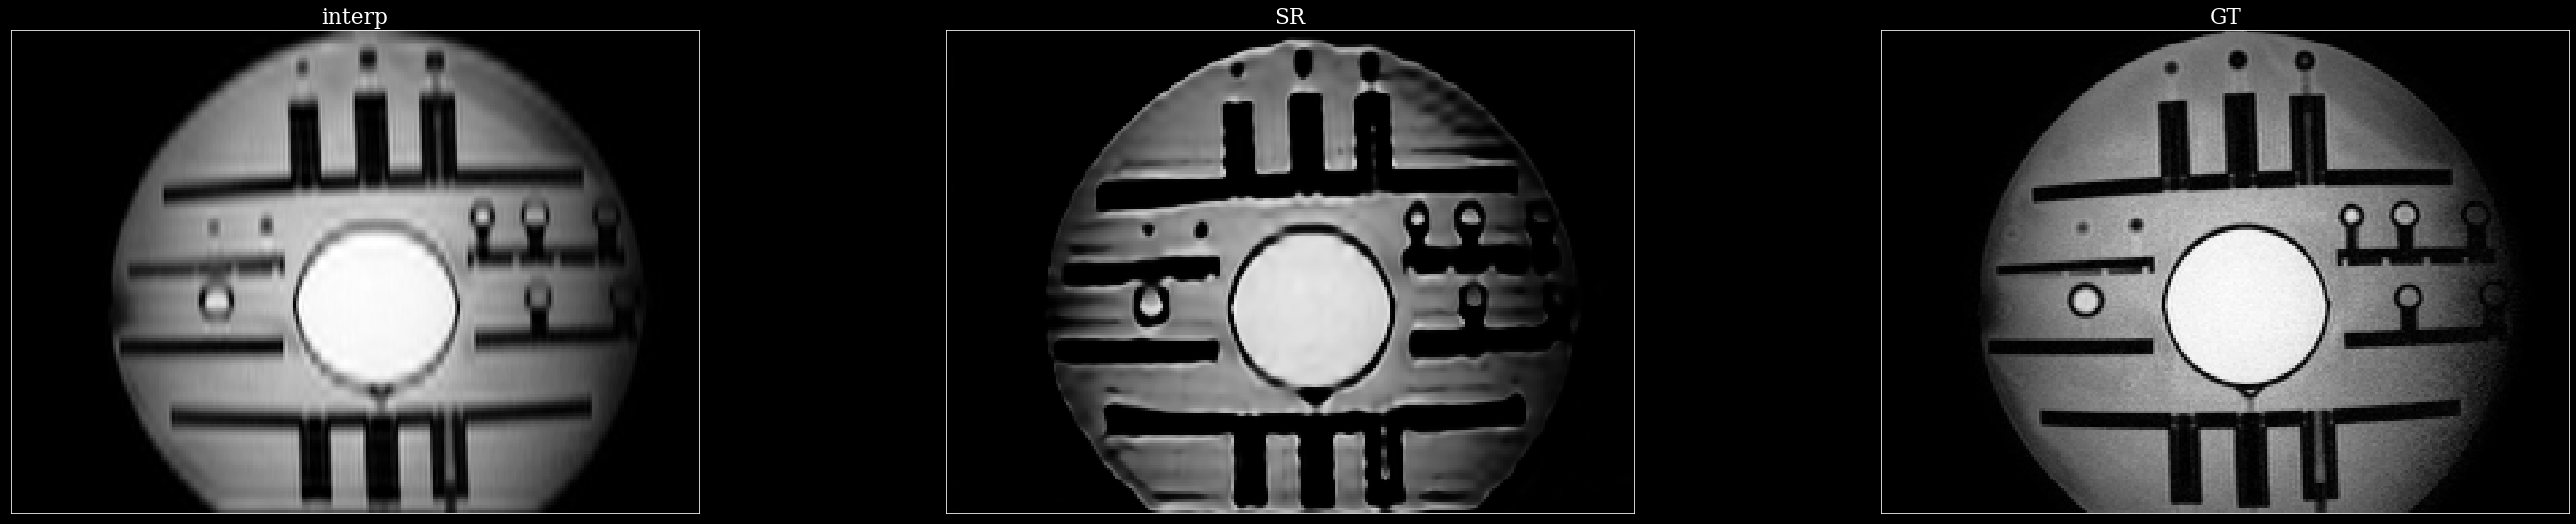

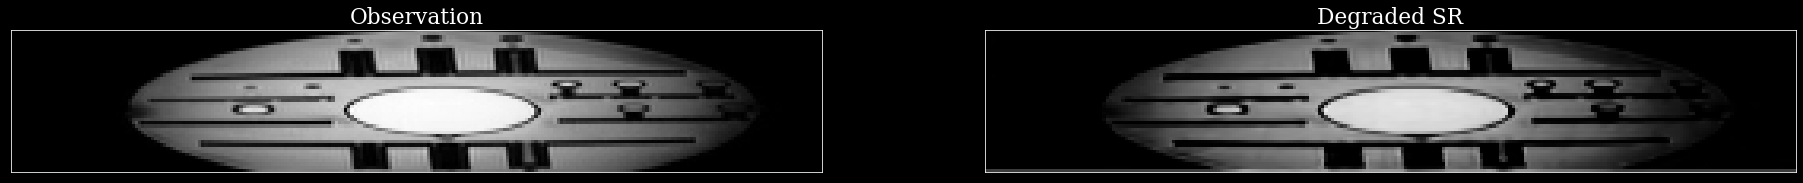

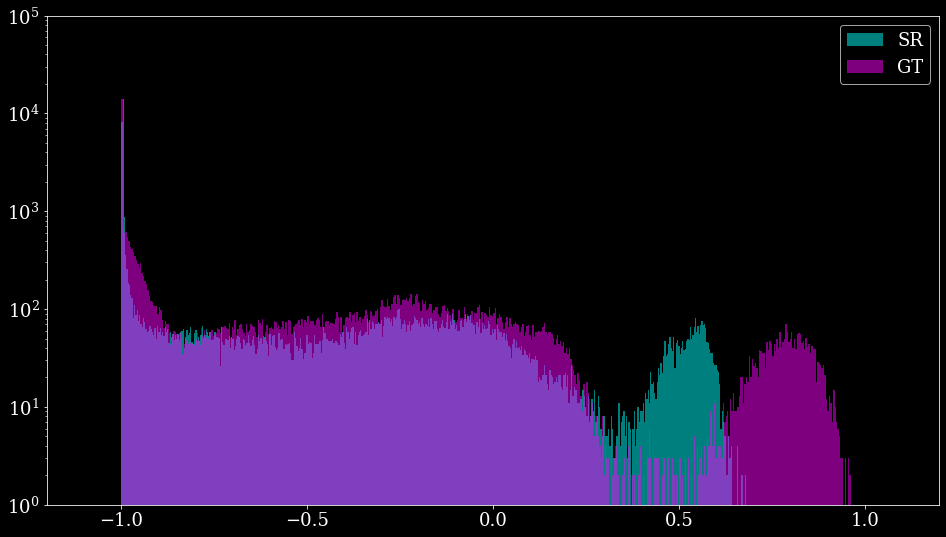

========== ILO at level 2 ==========
SR MSE: 2445.1975


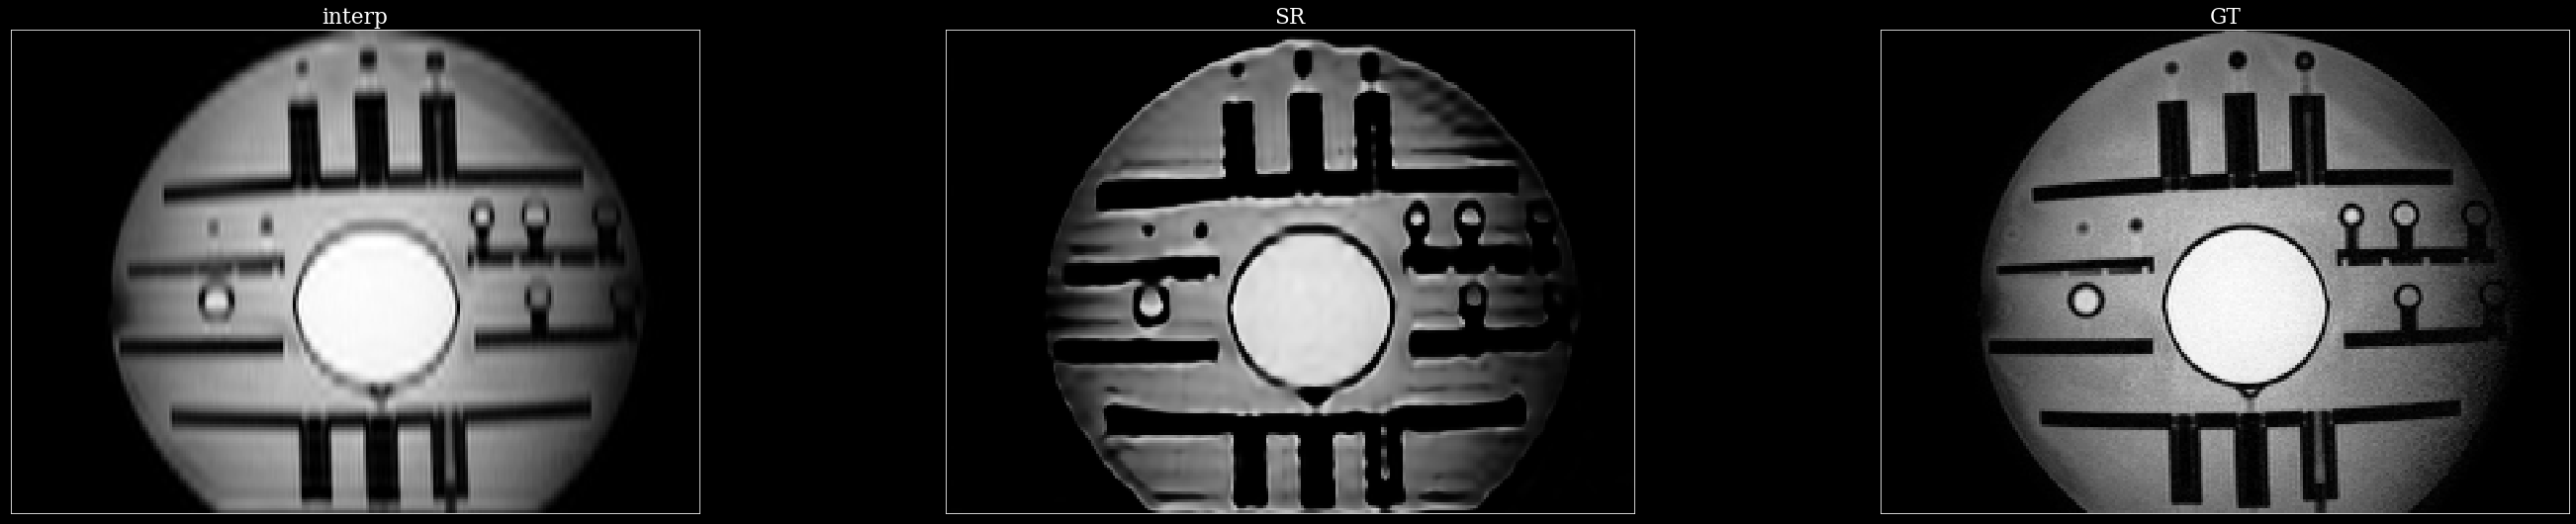

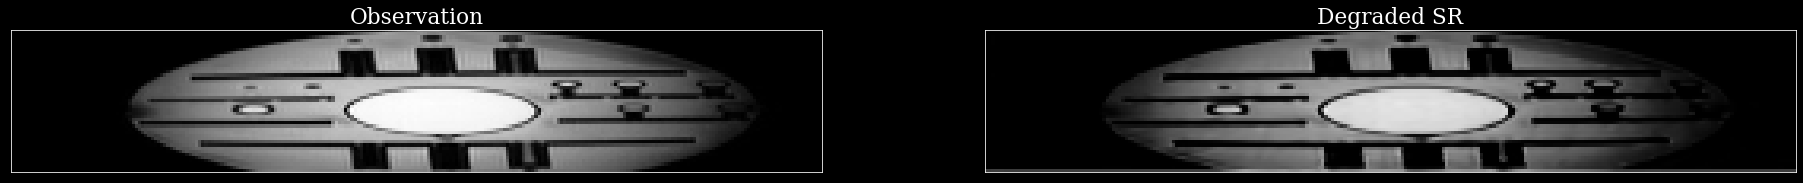

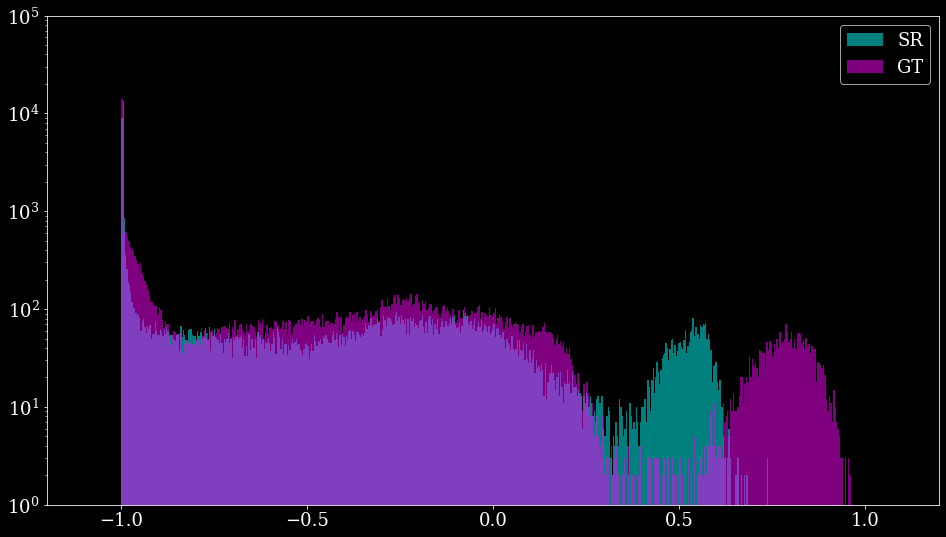

In [1029]:
vmin = gt.min()
vmax = gt.max()

ae_obs = model(obs_interp).detach().cpu().numpy().squeeze()[:, int(pad*scale):]

print("Auto-encoded MSE:", mse(ae_obs, gt))
plt.hist(ae_obs.flatten(), bins=512, color='cyan', alpha=0.5, label='AE Observation')
plt.hist(gt.flatten(), bins=512, color='magenta', alpha=0.5, label='GT')
plt.yscale('log')
plt.legend()
plt.xlim((-1.2, 1.2))
plt.ylim((1, 10**5))
plt.show()

print("Interp MSE:", mse(obs_interp.detach().cpu().numpy().squeeze()[:, int(pad*scale):], gt))
plt.hist(obs_interp.detach().cpu().numpy().flatten(), bins=512, color='cyan', alpha=0.5, label='5th Order B-spline Interp')
plt.hist(gt.flatten(), bins=512, color='magenta', alpha=0.5, label='GT')
plt.yscale('log')
plt.legend()
plt.xlim((-1.2, 1.2))
plt.ylim((1, 10**5))
plt.show()

multiplot(
        [obs_interp.detach().cpu().numpy().squeeze()[:, int(pad*scale):], ae_obs, gt],
        titles=['Observation', 'AE Observation', 'GT'],
        vmins=[vmin, vmin, vmin],
        vmaxs=[vmax, vmax, vmax],
    )


for i, pred in enumerate(preds):
    print("="*10, f"ILO at level {i}", "="*10)
    print("SR MSE:", mse(pred, gt))
    multiplot(
        [obs_interp.detach().cpu().numpy().squeeze()[:, int(pad*scale):], pred, gt],
        titles=['interp', 'SR', 'GT'],
        vmins=[vmin, vmin, vmin],
        vmaxs=[vmax, vmax, vmax],
    )
    
    multiplot(
        [
            obs.detach().cpu().numpy().squeeze()[:, int(pad):], 
            A(torch.from_numpy(pred).unsqueeze(1).to(device)).detach().cpu().numpy().squeeze(),
        ],
        titles=['Observation', 'Degraded SR'],
        vmins=[vmin, vmin],
        vmaxs=[vmax, vmax],
    )
    
    plt.hist(pred.flatten(), bins=512, color='cyan', alpha=0.5, label='SR')
    plt.hist(gt.flatten(), bins=512, color='magenta', alpha=0.5, label='GT')
    plt.yscale('log')
    plt.xlim((-1.2, 1.2))
    plt.ylim((1, 10**5))
    plt.legend()
    plt.show()